In [1]:
import sys

import numpy as np
import pickle
import os
import pandas as pd
from scipy import sparse

import time

import scanpy
import numpy as np

import torch
from torch import optim

import model_lord

import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import anndata as ad
import gc



/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
skin_rnaPath='/data/xinyi/shareseq/skin_rna.h5ad'
skin_rna=scanpy.read(skin_rnaPath)

skin_atacPath='/data/xinyi/shareseq/skin_atac.h5ad'
skin_atac=scanpy.read(skin_atacPath)

In [3]:
skin_atac.var['index']=np.arange(skin_atac.shape[1])

In [4]:
scanpy.pp.filter_genes(skin_rna, min_cells=300)
scanpy.pp.filter_genes(skin_atac, min_cells=300)

scanpy.pp.filter_cells(skin_atac, min_genes=300)
scanpy.pp.filter_cells(skin_rna, min_genes=300)
skin_atac=skin_atac[skin_rna.obs.index]

scanpy.pp.filter_genes(skin_rna, min_cells=300)
scanpy.pp.filter_genes(skin_atac, min_cells=300)
scanpy.pp.filter_cells(skin_atac, min_genes=300)
scanpy.pp.filter_cells(skin_rna, min_genes=300)
skin_atac=skin_atac[skin_rna.obs.index]


atac=skin_atac.X.toarray()
rna=skin_rna.X.toarray()

atac_posweight=(atac.size-np.sum(atac))/np.sum(atac)
rna_posweight=(rna.size-np.sum(rna))/np.sum(rna)

/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [5]:
log_data=True
normalize='minmax'
hiddenSize=1024
sharedSize=50
dSpecificSize=20

In [6]:
#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1

allIdx_all=np.arange(atac.shape[0])
np.random.shuffle(allIdx_all)
valIdx_all=allIdx_all[:int(pctVal*atac.shape[0])]
testIdx_all=allIdx_all[int(pctVal*atac.shape[0]):(int(pctVal*atac.shape[0])+int(pctTest*atac.shape[0]))]
trainIdx_all=allIdx_all[(int(pctVal*atac.shape[0])+int(pctTest*atac.shape[0])):]


In [7]:
#preprocess
if log_data:
    rna=np.log(rna+1/2)
    atac=np.log(atac+1/2)
if normalize=='zscore':
    scaler_rna = StandardScaler()
    scaler_rna.fit(rna[trainIdx_all])
    rna=scaler_rna.transform(rna)
    
    scaler_atac = StandardScaler()
    scaler_atac.fit(atac[trainIdx_all])
    atac=scaler_atac.transform(atac)
elif normalize=='minmax':
    rna=(rna-np.min(rna,axis=1,keepdims=True))/(np.max(rna,axis=1,keepdims=True)-np.min(rna,axis=1,keepdims=True))
    atac=(atac-np.min(atac,axis=1,keepdims=True))/(np.max(atac,axis=1,keepdims=True)-np.min(atac,axis=1,keepdims=True))

In [9]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

batchsize=512
saveFreq=100
epochs=10000
weight_decay=0
seed=3

dropout=0.01


testSaveName='shareseq_lord'
name='randNoise_sharedRecon_bceWweight_bce_morefilter'
modelsavepath_lord=os.path.join('/data/xinyi/shareseq/results/models',testSaveName,name)

nFeatures_rna=rna.shape[1]
nFeatures_atac=atac.shape[1]


train_nodes_idx=trainIdx_all
val_nodes_idx=valIdx_all

loadEpoch_decoders='4900'
loadEpoch_encoders='3900'

In [10]:
celltype_unique,celltype_labels,celltype_counts=np.unique(skin_atac.obs['celltype'][train_nodes_idx],return_counts=True,return_inverse=True)




### load DE

In [11]:
plotsavepath_de=os.path.join('/data/xinyi/shareseq/results/plots/',testSaveName,name,'de')
nsamples=36

In [12]:

with open(os.path.join(plotsavepath_de,'de_shared_all_centered_2bins_rna'), 'rb') as output:
    deShared_centered_2bins_rna=pickle.load(output)
with open(os.path.join(plotsavepath_de,'de_d_all_centered_2bins_rna'), 'rb') as output:
    deD_centered_2bins_rna=pickle.load(output)
    
with open(os.path.join(plotsavepath_de,'de_shared_all_centered_2bins_heldout_rna'), 'rb') as output:
    deShared_centered_2bins_heldout_rna=pickle.load(output)
with open(os.path.join(plotsavepath_de,'de_d_all_centered_2bins_heldout_rna'), 'rb') as output:
    deD_centered_2bins_heldout_rna=pickle.load(output)


In [13]:

with open(os.path.join(plotsavepath_de,'de_shared_all_centered_2bins_atac'), 'rb') as output:
    deShared_centered_2bins_atac=pickle.load(output)
with open(os.path.join(plotsavepath_de,'de_d_all_centered_2bins_atac'), 'rb') as output:
    deD_centered_2bins_atac=pickle.load(output)
    
with open(os.path.join(plotsavepath_de,'de_shared_all_centered_2bins_heldout_atac'), 'rb') as output:
    deShared_centered_2bins_heldout_atac=pickle.load(output)
with open(os.path.join(plotsavepath_de,'de_d_all_centered_2bins_heldout_atac'), 'rb') as output:
    deD_centered_2bins_heldout_atac=pickle.load(output)


### setup go

In [14]:
### enrichment using goatools adapted from https://github.com/mousepixels/sanbomics_scripts/blob/main/GO_in_python.ipynb
from genes_ncbi_mm_proteinCoding import GENEID2NT as GeneID2nt_hs

In [15]:
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

In [16]:
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("/data/xinyi/shareseq/go-basic.obo")

  EXISTS: go-basic.obo
  EXISTS: gene2go
/data/xinyi/shareseq/go-basic.obo: fmt(1.2) rel(2023-07-27) 46,356 Terms


In [17]:
mapper = {}

for key in GeneID2nt_hs:
    mapper[GeneID2nt_hs[key].Symbol] = GeneID2nt_hs[key].GeneID
    
inv_map = {v: k for k, v in mapper.items()}

In [18]:
# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[10090])
# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

HMS:0:00:03.494788 435,362 annotations, 29,895 genes, 19,162 GOs, 1 taxids READ: gene2go 


In [19]:
ns2assoc={'BP':ns2assoc['BP']}

In [20]:
goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_hs.keys(), # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
 68% 17,907 of 26,340 population items found in association


In [21]:
#run one time to initialize
GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]
    

# temp = goeaobj.ns2objgoea['CC'].assoc
# for item in temp:
#     GO_items += temp[item]
    

# temp = goeaobj.ns2objgoea['MF'].assoc
# for item in temp:
#     GO_items += temp[item]

In [22]:
def go_it(test_genes):
    print(f'input genes: {len(test_genes)}')
    
    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f'mapped genes: {len(mapped_genes)}')
    
    goea_results_all = goeaobj.run_study(mapped_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    GO = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                   x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: inv_map[y], x.study_items)),\
                   ], goea_results_sig)), columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes',\
                                                    'n_study', 'n_go', 'study_genes'])

    GO = GO[GO.n_genes > 1]
    return GO

### ATAC

In [296]:
atac_symbol=pd.read_csv('/data/xinyi/shareseq/skin_atac_symbol.csv',index_col=0)

In [297]:
pval_thresh=0.05
fc_thresh_atac=3
minCount=0

dePC_shared_atac=50
dePC_d_atac=20
minAgreement=30

In [299]:
#also taking into account direction of fold change & plotting

resDEsampling_atac=np.zeros((2,skin_atac.shape[1]))
for pc_i in range(dePC_shared_atac):
    resLogFC={0:np.array([]),-1:np.array([]),1:np.array([])}
    resNames={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
    resAgreement={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
    for h in range(nsamples):
        deRes_shared_centered=deShared_centered_2bins_atac[h]
        deRes_shared_centered_heldout=deShared_centered_2bins_heldout_atac[h]
        for deDirection in resLogFC.keys():
#             print(deDirection)
            if str(deDirection) not in deRes_shared_centered[pc_i].keys():
                continue
            if str(deDirection) not in deRes_shared_centered_heldout[pc_i].keys():
                continue
            resNames_h_val=deRes_shared_centered[pc_i][str(deDirection)].names.to_numpy()[np.logical_and(deRes_shared_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]
            resValues_h_val=deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges.to_numpy()[np.logical_and(deRes_shared_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]

            resNames_h_heldout=deRes_shared_centered_heldout[pc_i][str(deDirection)].names.to_numpy()[np.logical_and(deRes_shared_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]
            resValues_h_heldout=deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges.to_numpy()[np.logical_and(deRes_shared_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]

            resNames_h,valIdx_h,heldoutIdx_h=np.intersect1d(resNames_h_val,resNames_h_heldout,return_indices=True)
            sameDir=np.equal(resValues_h_val[valIdx_h]>0,resValues_h_heldout[heldoutIdx_h]>0)
            
            resAgreement[deDirection]=np.concatenate((resAgreement[deDirection],resNames_h[sameDir]))
            for fidx in range(np.sum(sameDir)):
                f=str(resNames_h[sameDir][fidx])
                if f not in resNames[deDirection]:
                    resNames[deDirection]=np.concatenate((resNames[deDirection],[f]))
                    resLogFC[deDirection]=np.concatenate((resLogFC[deDirection],[resValues_h_val[valIdx_h[sameDir]][fidx]]))
                else:
                    fidx_res=np.where(resNames[deDirection]==f)
                    resLogFC[deDirection][fidx_res]+=resValues_h_val[valIdx_h[sameDir]][fidx]
    for deDirection in resLogFC.keys():
        resNames_agree,resAgreement_counts=np.unique(resAgreement[deDirection],return_counts=True)
        resNames_agree=resNames_agree[resAgreement_counts>=minAgreement]

        _,shared_unique_idx,_=np.intersect1d(skin_atac.var_names,resNames_agree,return_indices=True)

        resDEsampling_atac[0,shared_unique_idx]+=1
        
for pc_i in range(dePC_d_atac):
    resLogFC={0:np.array([]),-1:np.array([]),1:np.array([])}
    resNames={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
    resAgreement={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
    for h in range(nsamples):
        deRes_d_centered=deD_centered_2bins_atac[h]
        deRes_d_centered_heldout=deD_centered_2bins_heldout_atac[h]
        for deDirection in resLogFC.keys():
#             print(deDirection)
            if str(deDirection) not in deRes_d_centered[pc_i].keys():
                continue
            if str(deDirection) not in deRes_d_centered_heldout[pc_i].keys():
                continue
            resNames_h_val=deRes_d_centered[pc_i][str(deDirection)].names.to_numpy()[np.logical_and(deRes_d_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]
            resValues_h_val=deRes_d_centered[pc_i][str(deDirection)].logfoldchanges.to_numpy()[np.logical_and(deRes_d_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]

            resNames_h_heldout=deRes_d_centered_heldout[pc_i][str(deDirection)].names.to_numpy()[np.logical_and(deRes_d_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]
            resValues_h_heldout=deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges.to_numpy()[np.logical_and(deRes_d_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh_atac))]

            resNames_h,valIdx_h,heldoutIdx_h=np.intersect1d(resNames_h_val,resNames_h_heldout,return_indices=True)
            sameDir=np.equal(resValues_h_val[valIdx_h]>0,resValues_h_heldout[heldoutIdx_h]>0)
            
            resAgreement[deDirection]=np.concatenate((resAgreement[deDirection],resNames_h[sameDir]))
            for fidx in range(np.sum(sameDir)):
                f=str(resNames_h[sameDir][fidx])
                if f not in resNames[deDirection]:
                    resNames[deDirection]=np.concatenate((resNames[deDirection],[f]))
                    resLogFC[deDirection]=np.concatenate((resLogFC[deDirection],[resValues_h_val[valIdx_h[sameDir]][fidx]]))
                else:
                    fidx_res=np.where(resNames[deDirection]==f)
                    resLogFC[deDirection][fidx_res]+=resValues_h_val[valIdx_h[sameDir]][fidx]
    for deDirection in resLogFC.keys():
        resNames_agree,resAgreement_counts=np.unique(resAgreement[deDirection],return_counts=True)
        resNames_agree=resNames_agree[resAgreement_counts>=minAgreement]

        _,d_unique_idx,_=np.intersect1d(skin_atac.var_names,resNames_agree,return_indices=True)

        resDEsampling_atac[1,d_unique_idx]+=1

In [300]:
skin_atac.var['symbol']=atac_symbol.to_numpy()[skin_atac.var['index']]

In [301]:
skin_atac.var

,features,index,n_cells,mean,std,symbol,gPos
chrX-143482906-143483206,chrX-143482906-143483206,0,15761,1.079350,1.031489,Pak3,Distal Intergenic
chr6-3200976-3201276,chr6-3200976-3201276,1,17423,1.272123,1.092964,Gm8579,Distal Intergenic
chr9-123461850-123462150,chr9-123461850-123462150,2,9112,0.540614,0.834564,Lars2,3' UTR
chr1-56782095-56782395,chr1-56782095-56782395,3,8822,0.526171,0.831808,Hsfy2,Distal Intergenic
chr9-56223668-56223968,chr9-56223668-56223968,4,7926,0.458840,0.781393,Peak1,Exon
...,...,...,...,...,...,...,...
chr15-3493148-3493448,chr15-3493148-3493448,70263,301,0.014136,0.144655,Ghr,Intron
chr14-76616109-76616409,chr14-76616109-76616409,70265,358,0.018239,0.170323,Serp2,Distal Intergenic
chr13-63120715-63121015,chr13-63120715-63121015,70267,414,0.020209,0.176596,Aopep,Intron
chr11-100288214-100288514,chr11-100288214-100288514,70280,446,0.022241,0.187026,Krt42,Intron


In [302]:
resDEsampling_atac_norm=np.copy(resDEsampling_atac)
resDEsampling_atac_names=skin_atac.var['symbol'][skin_atac.var_names[np.sum(resDEsampling_atac_norm,axis=0)>minCount]]
for g in range(resDEsampling_atac_names.size):
    resDEsampling_atac_names[g]=resDEsampling_atac_names[g]
resDEsampling_atac_norm=np.copy(resDEsampling_atac_norm[:,np.sum(resDEsampling_atac_norm,axis=0)>minCount])
go_shared_atac=go_it(resDEsampling_atac_names[resDEsampling_atac_norm[0]>0])
go_d_atac=go_it(resDEsampling_atac_names[resDEsampling_atac_norm[1]>0])


input genes: 5556
mapped genes: 4802

Runing MF Ontology Analysis: current study set of 4802 IDs.
 87%  2,739 of  3,150 study items found in association
 66%  3,150 of  4,802 study items found in population(26340)
Calculating 4,629 uncorrected p-values using fisher_scipy_stats
   4,629 terms are associated with 17,214 of 26,340 population items
   2,251 terms are associated with  2,739 of  3,150 study items
  METHOD fdr_bh:
     120 GO terms found significant (< 0.05=alpha) (115 enriched +   5 purified): statsmodels fdr_bh
   2,402 study items associated with significant GO IDs (enriched)
      47 study items associated with significant GO IDs (purified)
input genes: 4175
mapped genes: 3620

Runing MF Ontology Analysis: current study set of 3620 IDs.
 87%  2,277 of  2,630 study items found in association
 73%  2,630 of  3,620 study items found in population(26340)
Calculating 4,629 uncorrected p-values using fisher_scipy_stats
   4,629 terms are associated with 17,214 of 26,340 populat

In [307]:
allgo=np.unique(np.concatenate((go_shared_atac['term'],go_d_atac['term'])))
print(allgo.size)
resDEsampling_atac_go=np.zeros((2,allgo.size))
go_shared_atac.index=go_shared_atac['term']
go_d_atac.index=go_d_atac['term']
for goname_idx in range(allgo.size):
    goname=allgo[goname_idx]
    if goname in go_shared_atac.index:
        gogenes=go_shared_atac.loc[goname,'study_genes']
        _,geneidx,_=np.intersect1d(resDEsampling_atac_names[resDEsampling_atac_norm[0]>0].astype(str),gogenes,return_indices=True)
        resDEsampling_atac_go[0,goname_idx]=np.sum(resDEsampling_atac_norm[0,geneidx])
    if goname in go_d_atac.index:
        gogenes=go_d_atac.loc[goname,'study_genes']
        _,geneidx,_=np.intersect1d(resDEsampling_atac_names[resDEsampling_atac_norm[1]>0].astype(str),gogenes,return_indices=True)
        resDEsampling_atac_go[1,goname_idx]=np.sum(resDEsampling_atac_norm[1,geneidx])

156


In [310]:
atac_allAnno=pd.read_csv('/data/xinyi/shareseq/skin_atac_allAnnotations.csv',index_col=0)
import re
atac_gPos=np.repeat(None,atac_allAnno.shape[0])
atac_anno=np.array(atac_allAnno['annotation'])
for i in range(atac_allAnno.shape[0]):
    atac_gPos[i]=str(re.sub("[\(\[].*?[\)\]]", "", atac_anno[i]))
skin_atac.var['gPos']=atac_gPos[skin_atac.var['index']]


3' UTR
5' UTR
Distal Intergenic
Downstream 
Exon 
Intron 
input genes: 2234
mapped genes: 1987

Runing MF Ontology Analysis: current study set of 1987 IDs.
 89%  1,238 of  1,398 study items found in association
 70%  1,398 of  1,987 study items found in population(26340)
Calculating 4,629 uncorrected p-values using fisher_scipy_stats
   4,629 terms are associated with 17,214 of 26,340 population items
   1,428 terms are associated with  1,238 of  1,398 study items
  METHOD fdr_bh:
      84 GO terms found significant (< 0.05=alpha) ( 82 enriched +   2 purified): statsmodels fdr_bh
   1,081 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
input genes: 1664
mapped genes: 1482

Runing MF Ontology Analysis: current study set of 1482 IDs.
 87%    995 of  1,143 study items found in association
 77%  1,143 of  1,482 study items found in population(26340)
Calculating 4,629 uncorrected p-values using fisher_scipy_stats
 

/tmp/ipykernel_2409790/4182187725.py:32: RuntimeWarning: invalid value encountered in true_divide
  resDEsampling_atac_norm_go=resDEsampling_atac_go/np.sum(resDEsampling_atac_go,axis=0,keepdims=True)


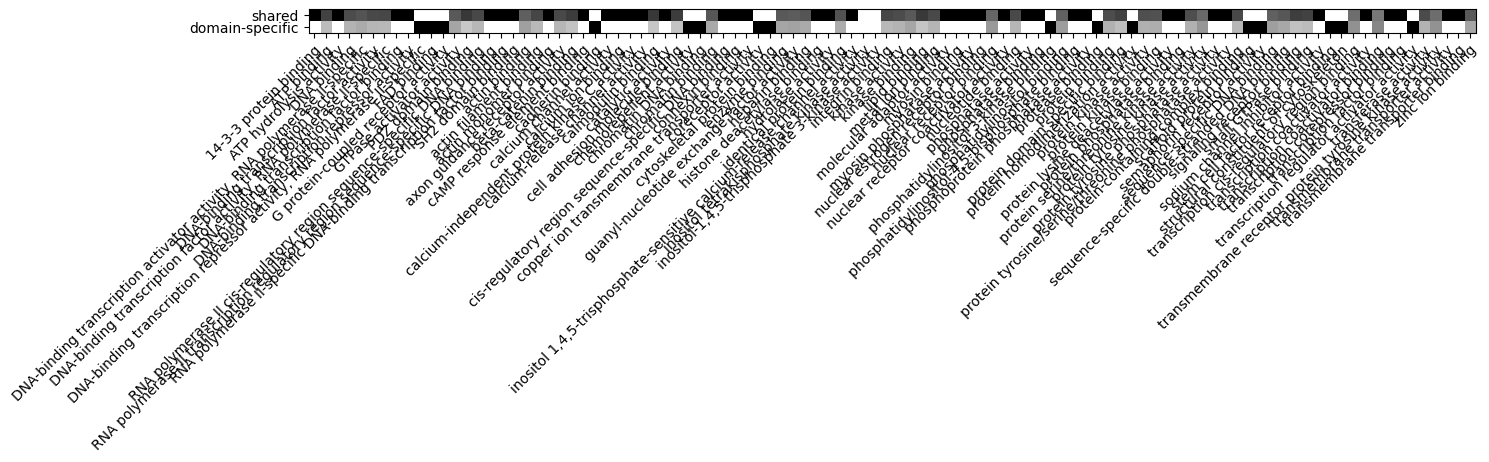

Promoter
input genes: 1040
mapped genes: 945

Runing MF Ontology Analysis: current study set of 945 IDs.
 87%    777 of    893 study items found in association
 94%    893 of    945 study items found in population(26340)
Calculating 4,629 uncorrected p-values using fisher_scipy_stats
   4,629 terms are associated with 17,214 of 26,340 population items
   1,105 terms are associated with    777 of    893 study items
  METHOD fdr_bh:
      22 GO terms found significant (< 0.05=alpha) ( 20 enriched +   2 purified): statsmodels fdr_bh
     591 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
input genes: 855
mapped genes: 780

Runing MF Ontology Analysis: current study set of 780 IDs.
 86%    634 of    735 study items found in association
 94%    735 of    780 study items found in population(26340)
Calculating 4,629 uncorrected p-values using fisher_scipy_stats
   4,629 terms are associated with 17,214 of 26,340 pop

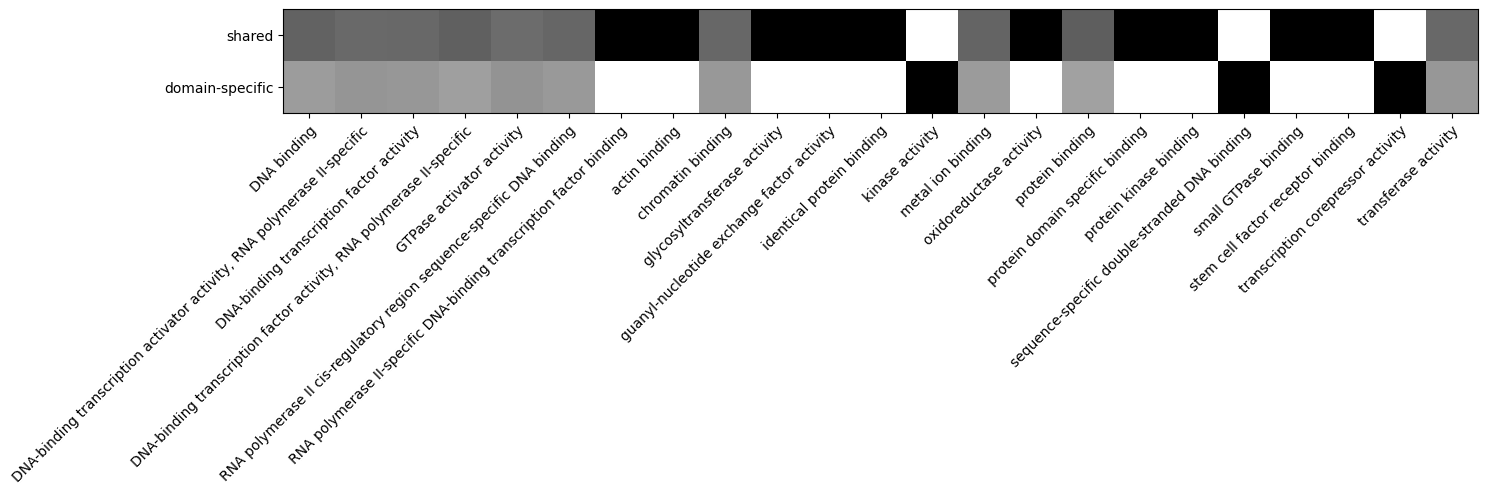

In [315]:
resDEsampling_atac_norm=np.copy(resDEsampling_atac)
resDEsampling_atac_names=skin_atac.var['symbol'][skin_atac.var_names[np.sum(resDEsampling_atac_norm,axis=0)>minCount]]
resDEsampling_atac_gPos=skin_atac.var['gPos'][skin_atac.var_names[np.sum(resDEsampling_atac_norm,axis=0)>minCount]]
for g in range(resDEsampling_atac_names.size):
    resDEsampling_atac_names[g]=resDEsampling_atac_names[g]
resDEsampling_atac_norm=np.copy(resDEsampling_atac_norm[:,np.sum(resDEsampling_atac_norm,axis=0)>minCount])

for gpos_i in np.unique(resDEsampling_atac_gPos):
    print(gpos_i)
    if gpos_i!='Intron ' and gpos_i!='Promoter':
        continue
    resDEsampling_atac_names_i=resDEsampling_atac_names[resDEsampling_atac_gPos==gpos_i]
    resDEsampling_atac_norm_i=resDEsampling_atac_norm[:,resDEsampling_atac_gPos==gpos_i]
    go_shared_atac=go_it(resDEsampling_atac_names_i[resDEsampling_atac_norm_i[0]>0])
    go_d_atac=go_it(resDEsampling_atac_names_i[resDEsampling_atac_norm_i[1]>0])
    
    allgo=np.unique(np.concatenate((go_shared_atac['term'],go_d_atac['term'])))
    print(allgo.size)
    resDEsampling_atac_go=np.zeros((2,allgo.size))
    go_shared_atac.index=go_shared_atac['term']
    go_d_atac.index=go_d_atac['term']
    for goname_idx in range(allgo.size):
        goname=allgo[goname_idx]
        if goname in go_shared_atac.index:
            gogenes=go_shared_atac.loc[goname,'study_genes']
            _,geneidx,_=np.intersect1d(resDEsampling_atac_names_i[resDEsampling_atac_norm_i[0]>0].astype(str),gogenes,return_indices=True)
            resDEsampling_atac_go[0,goname_idx]=np.sum(resDEsampling_atac_norm_i[0,geneidx])
        if goname in go_d_atac.index:
            gogenes=go_d_atac.loc[goname,'study_genes']
            _,geneidx,_=np.intersect1d(resDEsampling_atac_names_i[resDEsampling_atac_norm_i[1]>0],gogenes,return_indices=True)
            resDEsampling_atac_go[1,goname_idx]=np.sum(resDEsampling_atac_norm_i[1,geneidx])
    resDEsampling_atac_norm_go=resDEsampling_atac_go/np.sum(resDEsampling_atac_go,axis=0,keepdims=True)

    fig, ax = plt.subplots(figsize=(15, 30))
    im=ax.imshow(resDEsampling_atac_norm_go,cmap='binary',vmin=0,vmax=1)
    ax.set_yticks(np.arange(resDEsampling_atac_norm_go.shape[0]))
    ax.set_yticklabels(np.array(['shared','domain-specific']))
    ax.set_xticks(np.arange(resDEsampling_atac_norm_go.shape[1]))
    ax.set_xticklabels(allgo)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    # fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(plotsavepath_de,'de_atac_nocommon_go_'+gpos_i+'.pdf'))
    plt.show()

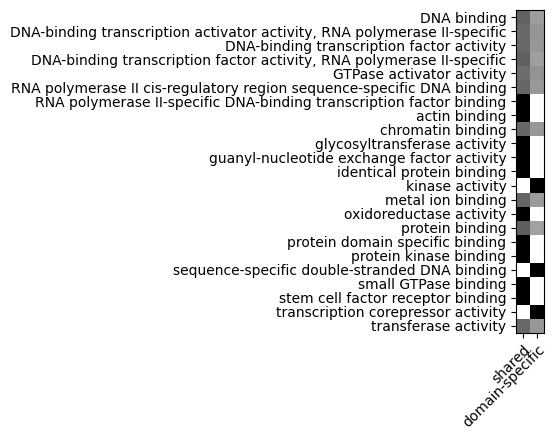

In [324]:
fig, ax = plt.subplots(figsize=(8, 4.5))
im=ax.imshow(resDEsampling_atac_norm_go.T,cmap='binary',vmin=0,vmax=1)
ax.set_xticks(np.arange(resDEsampling_atac_norm_go.shape[0]))
ax.set_xticklabels(np.array(['shared','domain-specific']))
ax.set_yticks(np.arange(resDEsampling_atac_norm_go.shape[1]))
ax.set_yticklabels(allgo)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
# fig.colorbar(im)
fig.tight_layout()
plt.savefig(os.path.join(plotsavepath_de,'de_atac_nocommon_go_T_'+gpos_i+'.pdf'))
plt.show()

3' UTR
5' UTR
Distal Intergenic
Downstream 
Exon 
Intron 
Promoter
input genes: 1040
mapped genes: 945

Runing BP Ontology Analysis: current study set of 945 IDs.
 92%    824 of    893 study items found in association
 94%    893 of    945 study items found in population(26340)
Calculating 12,653 uncorrected p-values using fisher_scipy_stats
  12,653 terms are associated with 17,907 of 26,340 population items
   3,886 terms are associated with    824 of    893 study items
  METHOD fdr_bh:
      37 GO terms found significant (< 0.05=alpha) ( 34 enriched +   3 purified): statsmodels fdr_bh
     359 study items associated with significant GO IDs (enriched)
      26 study items associated with significant GO IDs (purified)
input genes: 855
mapped genes: 780

Runing BP Ontology Analysis: current study set of 780 IDs.
 91%    666 of    735 study items found in association
 94%    735 of    780 study items found in population(26340)
Calculating 12,653 uncorrected p-values using fisher_scipy_s

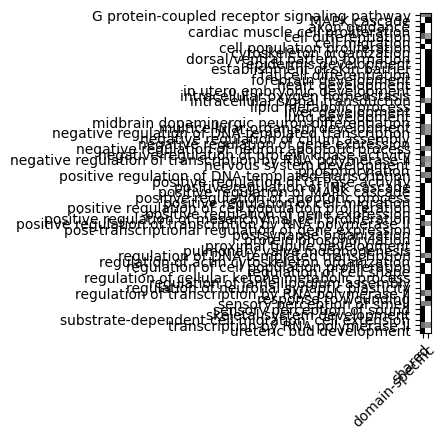

In [334]:
resDEsampling_atac_norm=np.copy(resDEsampling_atac)
resDEsampling_atac_names=skin_atac.var['symbol'][skin_atac.var_names[np.sum(resDEsampling_atac_norm,axis=0)>minCount]]
resDEsampling_atac_gPos=skin_atac.var['gPos'][skin_atac.var_names[np.sum(resDEsampling_atac_norm,axis=0)>minCount]]
for g in range(resDEsampling_atac_names.size):
    resDEsampling_atac_names[g]=resDEsampling_atac_names[g]
resDEsampling_atac_norm=np.copy(resDEsampling_atac_norm[:,np.sum(resDEsampling_atac_norm,axis=0)>minCount])

for gpos_i in np.unique(resDEsampling_atac_gPos):
    print(gpos_i)
    if gpos_i!='Promoter':
        continue
    resDEsampling_atac_names_i=resDEsampling_atac_names[resDEsampling_atac_gPos==gpos_i]
    resDEsampling_atac_norm_i=resDEsampling_atac_norm[:,resDEsampling_atac_gPos==gpos_i]
    go_shared_atac=go_it(resDEsampling_atac_names_i[resDEsampling_atac_norm_i[0]>0])
    go_d_atac=go_it(resDEsampling_atac_names_i[resDEsampling_atac_norm_i[1]>0])
    
    allgo=np.unique(np.concatenate((go_shared_atac['term'],go_d_atac['term'])))
    print(allgo.size)
    resDEsampling_atac_go=np.zeros((2,allgo.size))
    go_shared_atac.index=go_shared_atac['term']
    go_d_atac.index=go_d_atac['term']
    for goname_idx in range(allgo.size):
        goname=allgo[goname_idx]
        if goname in go_shared_atac.index:
            gogenes=go_shared_atac.loc[goname,'study_genes']
            _,geneidx,_=np.intersect1d(resDEsampling_atac_names_i[resDEsampling_atac_norm_i[0]>0].astype(str),gogenes,return_indices=True)
            resDEsampling_atac_go[0,goname_idx]=np.sum(resDEsampling_atac_norm_i[0,geneidx])
        if goname in go_d_atac.index:
            gogenes=go_d_atac.loc[goname,'study_genes']
            _,geneidx,_=np.intersect1d(resDEsampling_atac_names_i[resDEsampling_atac_norm_i[1]>0],gogenes,return_indices=True)
            resDEsampling_atac_go[1,goname_idx]=np.sum(resDEsampling_atac_norm_i[1,geneidx])
    resDEsampling_atac_norm_go=resDEsampling_atac_go/np.sum(resDEsampling_atac_go,axis=0,keepdims=True)

    fig, ax = plt.subplots(figsize=(8, 4.5))
    im=ax.imshow(resDEsampling_atac_norm_go.T,cmap='binary',vmin=0,vmax=1)
    ax.set_xticks(np.arange(resDEsampling_atac_norm_go.shape[0]))
    ax.set_xticklabels(np.array(['shared','domain-specific']))
    ax.set_yticks(np.arange(resDEsampling_atac_norm_go.shape[1]))
    ax.set_yticklabels(allgo)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    # fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(plotsavepath_de,'de_atac_nocommon_go_T_'+gpos_i+'_BP.pdf'))
    plt.show()

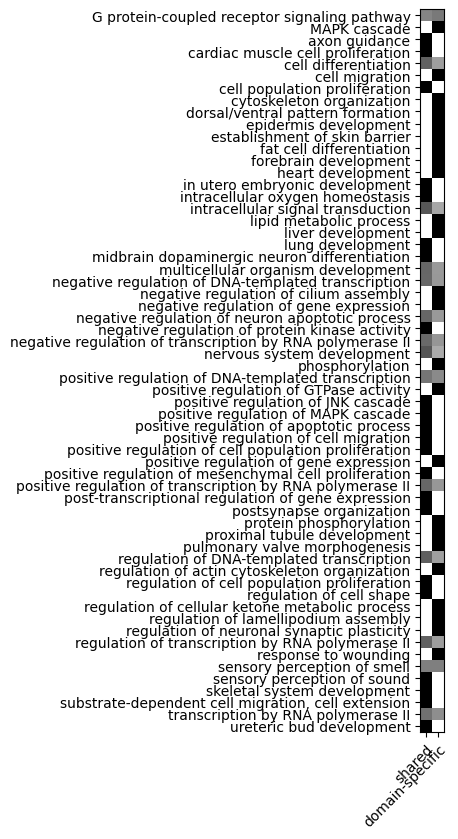

In [342]:
fig, ax = plt.subplots(figsize=(6, 8.5))
im=ax.imshow(resDEsampling_atac_norm_go.T,cmap='binary',vmin=0,vmax=1)
ax.set_xticks(np.arange(resDEsampling_atac_norm_go.shape[0]))
ax.set_xticklabels(np.array(['shared','domain-specific']))
ax.set_yticks(np.arange(resDEsampling_atac_norm_go.shape[1]))
ax.set_yticklabels(allgo)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
# fig.colorbar(im)
fig.tight_layout()
plt.savefig(os.path.join(plotsavepath_de,'de_atac_nocommon_go_T_'+gpos_i+'_BP.pdf'))
plt.show()